# Deep Learning for Deciphering Traffic Signs
# Draft Models Notebook
_________________________________________________________________________________________________________________________________________________________________________________

##### Contributors:
 Victor Floriano, Yifan Fan, Jose Salerno

## Problem Statement & Motivation
As the world advances towards autonomous vehicles, our team has observed the remarkable efforts of large car manufacturers, who are working with data scientists to develop fully autonomous cars. Our team is excited to contribute to the development of this technology by creating a neural network model that will be able to classify different traffic signs. Our ultimate goal is to assist car makers in overcoming the challenges they may face in implementing neural network models that effectively read traffic signs and further their efforts toward a fully autonomous car or assisted driving. We believe autonomous driving to be an important problem to solve due to the great economic benefits it can generate for car manufacturers and the improvement of general driving safety.

## Data Preparation
 We've selected the German Traffic Sign Recognition Benchmark (GTSRB) as our primary dataset. It's renowned for its complexity, featuring over 50,000 images across more than 40 classes of traffic signs. The GTSRB is publicly accessible through two resources. To efficiently manage the extensive and complex GTSRB dataset, our strategy integrates preprocessing for uniformity, data augmentation for robustness, and batch processing for computational efficiency. We'll employ distributed computing to parallelize operations, enhancing processing speed, and use stratified sampling for quick experimentation without compromising representativeness.



---





## Draft Models

This notebook represents the initial phase of our project's model creation, focusing on experimenting with MLP (Multi-Layer Perceptron) and CNN (Convolutional Neural Network) models. The primary goal of this phase was to explore different model architectures and their performance in our specific use case. 

Due to the constraints of the Colab environment, this initial phase was limited in terms of computational resources. Despite these limitations, the insights gained from this exploration were instrumental in guiding our approach to model development.

These are the final notebooks of our models:

- MLP_Models.ipynb

- CNN_Models.ipynb

- SVM_Baseline_Model.ipynb
__________________________________________________________________________________________________________________________________

Results: 
- MLP initial Validation Accuracy: 0.39
- CNN initial Validation Accuracy: 0.45

## Importing Packages

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
enable_wandb = True
use_gpu = True
gpu_available = torch.cuda.is_available()
gpu_available

/usr4/ba820/jsale017/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


False

In [3]:
!pip install wandb -qU

In [4]:
import wandb

In [ ]:
wandb.login()

In [6]:
#Loading images - from Datacamp CNN course (cloud example)
from torchvision.datasets import ImageFolder
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((56,56))
])

dataset_train = ImageFolder(
    'Train',
    transform = train_transforms
)

In [7]:
train_dataset, val_dataset = random_split(dataset_train, [0.8, 0.2])

### Visualizing Data

torch.Size([1, 3, 56, 56])
Label: tensor([32])
tensor([32])


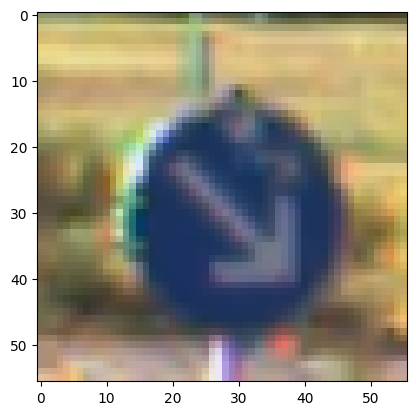

In [11]:
from torch.utils.data import DataLoader

#Trying to display images
dataloader_train = DataLoader(
    dataset_train,
    shuffle=True,
    batch_size=1,
)

image, label = next(iter(dataloader_train))
print(image.shape)
print('Label:',label)
print(label)

image = image.squeeze().permute(1,2,0)

plt.imshow(image)
plt.show()

### Dealing With Class Imbalance

In [34]:
num_samples = 39219
num_images_per_class = {
    0: 210, 1: 2220, 10: 2010, 11: 1320, 12: 2100, 13: 2160, 14: 780, 15: 630,
    16: 420, 17: 1110, 18: 1200, 19: 210, 2: 2250, 20: 360, 21: 330, 22: 390,
    23: 510, 24: 270, 25: 1500, 26: 600, 27: 240, 28: 540, 29: 270, 3: 1410,
    30: 450, 31: 780, 32: 240, 33: 689, 34: 420, 35: 1200, 36: 390, 37: 210,
    38: 2070, 39: 300, 4: 1980, 40: 360, 41: 240, 42: 240, 5: 1860, 6: 420,
    7: 1440, 8: 1410, 9: 1470
}

class_weights = {}
for class_id, num_images in num_images_per_class.items():
    weight_for_class = num_samples / (num_images * 2)
    class_weights[class_id] = weight_for_class

print("Class Weights:")
for class_id, weight in class_weights.items():
    print(f"Class {class_id}: {weight:.4f}")

Class Weights:
Class 0: 93.3786
Class 1: 8.8331
Class 10: 9.7560
Class 11: 14.8557
Class 12: 9.3379
Class 13: 9.0785
Class 14: 25.1404
Class 15: 31.1262
Class 16: 46.6893
Class 17: 17.6662
Class 18: 16.3412
Class 19: 93.3786
Class 2: 8.7153
Class 20: 54.4708
Class 21: 59.4227
Class 22: 50.2808
Class 23: 38.4500
Class 24: 72.6278
Class 25: 13.0730
Class 26: 32.6825
Class 27: 81.7062
Class 28: 36.3139
Class 29: 72.6278
Class 3: 13.9074
Class 30: 43.5767
Class 31: 25.1404
Class 32: 81.7062
Class 33: 28.4608
Class 34: 46.6893
Class 35: 16.3412
Class 36: 50.2808
Class 37: 93.3786
Class 38: 9.4732
Class 39: 65.3650
Class 4: 9.9038
Class 40: 54.4708
Class 41: 81.7062
Class 42: 81.7062
Class 5: 10.5427
Class 6: 46.6893
Class 7: 13.6177
Class 8: 13.9074
Class 9: 13.3398


In [35]:
class_weights = torch.tensor([
    93.3786, 8.8331, 9.7560, 14.8557, 9.3379, 9.0785, 25.1404, 31.1262, 46.6893, 17.6662,
    16.3412, 93.3786, 8.7153, 54.4708, 59.4227, 50.2808, 38.4500, 72.6278, 13.0730, 32.6825,
    81.7062, 36.3139, 72.6278, 13.9074, 43.5767, 25.1404, 81.7062, 28.4608, 46.6893, 16.3412,
    50.2808, 93.3786, 9.4732, 65.3650, 9.9038, 54.4708, 81.7062, 81.7062, 10.5427, 46.6893,
    13.6177, 13.9074, 13.3398
])

criterion = nn.BCEWithLogitsLoss(weight= class_weights)

## 1. Initial Model Creation

## Hyperparameters

In [60]:
# Hyperparameters

configs = {
    "experiment_name": "first_experiment_CNN",
    "data_augmentation":True,

    # Data
    "img_dimensions" : (3,56,56),
    "batch_size" : 350,
    "num_classes" : 43,

    # CNN
    "filter_sizes" : [4, 16, 32, 64],
    "kernel_size" : 5,
    "stride": 2,
    "padding":2,

    #Optimzation
    "learning_rate" : 0.0001,
    "epochs" : 25,
    "weight_decay" : 0.00001,
    "epochs" : 35
}


In [61]:
train_loader = DataLoader(dataset=train_dataset, batch_size = configs['batch_size'], shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size = configs['batch_size'], shuffle=False)

## Data Augmentation


In [62]:
if configs["data_augmentation"]:
  transform = transforms.Compose([
      transforms.RandomHorizontalFlip(0.5),
      transforms.Resize(56),
      transforms.RandomRotation(45),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
else:
  transform = transforms.Compose([
      transforms.Resize(56),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

### A. Pytorch Sequential MLP


#### Sequential Model

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
if enable_wandb:
  wandb.init(
    project="Deciphering Traffic Signs",
    name=configs["experiment_name"],
    config=configs)

In [ ]:
!pip install -U torchmetrics
import torchmetrics

In [18]:
class model(nn.Module):
    def __init__(self, input_size, num_classes):
        super(model, self).__init__()
        self.fc1 = nn.Linear(input_size, 250)
        self.fc2 = nn.Linear(250, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [19]:
input_size = configs["img_dimensions"][0] * configs["img_dimensions"][1] * configs["img_dimensions"][2]
num_classes = configs["num_classes"]

In [20]:
from torchinfo import summary

In [21]:
model = model(input_size = input_size, num_classes = num_classes)
summary(model)

Layer (type:depth-idx)                   Param #
model                                    --
├─Linear: 1-1                            2,352,250
├─Linear: 1-2                            32,128
├─Linear: 1-3                            5,547
Total params: 2,389,925
Trainable params: 2,389,925
Non-trainable params: 0

In [22]:
criterion = nn.CrossEntropyLoss()

In [23]:
optimizer = optim.Adam(model.parameters(), lr = configs['learning_rate'], weight_decay = configs['weight_decay'])

### Training

In [24]:
import torchmetrics

In [25]:
def get_accuracy(dataloader, model):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    acc = torchmetrics.Accuracy(task="MULTICLASS", num_classes=configs['num_classes']).to(device)

    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
                
            outputs = model(images)
            preds = torch.argmax(outputs, axis=1)
            acc.update(preds, labels)

    accuracy = acc.compute()
    model.train()
    return accuracy

In [26]:
def get_loss(loader):
    model.eval()
    loss = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            if gpu_available and use_gpu:
                images = images.cuda()
                labels = labels.cuda()
            outputs = model(images)
            loss = loss + criterion(outputs, labels)
    return loss / len(loader.dataset)

In [27]:
class EarlyStopper:
    def __init__(self, patience=1):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            torch.save(model.state_dict(), "./best_model.pt")
        elif validation_loss > self.min_validation_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
early_stopper = EarlyStopper(patience=3)

In [28]:
# Training loop
for epoch in range(configs['epochs']):
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        if gpu_available and use_gpu:
            images = images.cuda()
            labels = labels.cuda()
            model = model.cuda()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print("Epoch", epoch + 1, " batch", i + 1, ". Training Loss: ", loss.item())
            if enable_wandb:
                wandb.log({"loss": loss})

    # Calculate training and validation accuracy
    train_acc = get_accuracy(train_loader, model)
    val_acc = get_accuracy(val_loader, model)

    print(f'Epoch [{epoch + 1}/{configs["epochs"]}], Train Accuracy: {train_acc.item():.4f}, Validation Accuracy: {val_acc.item():.4f}')

    if enable_wandb:
        wandb.log({"epoch": epoch + 1, "train_accuracy": train_acc.item(), "val_accuracy": val_acc.item()})

    # Calculate validation loss
    validation_loss = get_loss(val_loader)

    # Check for early stopping
    if early_stopper.early_stop(validation_loss):
        print("Validation loss hasn't dropped. Early stopping!")
        break

Epoch 1  batch 1 . Training Loss:  3.761314630508423
Epoch [1/35], Train Accuracy: 0.1475, Validation Accuracy: 0.1505
Epoch 2  batch 1 . Training Loss:  3.694185256958008
Epoch [2/35], Train Accuracy: 0.2078, Validation Accuracy: 0.2160
Epoch 3  batch 1 . Training Loss:  3.634922504425049
Epoch [3/35], Train Accuracy: 0.2098, Validation Accuracy: 0.2172
Epoch 4  batch 1 . Training Loss:  3.626262664794922
Epoch [4/35], Train Accuracy: 0.2392, Validation Accuracy: 0.2455
Epoch 5  batch 1 . Training Loss:  3.563722848892212
Epoch [5/35], Train Accuracy: 0.2610, Validation Accuracy: 0.2691
Epoch 6  batch 1 . Training Loss:  3.5766592025756836
Epoch [6/35], Train Accuracy: 0.2653, Validation Accuracy: 0.2752
Epoch 7  batch 1 . Training Loss:  3.540334939956665
Epoch [7/35], Train Accuracy: 0.2673, Validation Accuracy: 0.2771
Epoch 8  batch 1 . Training Loss:  3.540482997894287
Epoch [8/35], Train Accuracy: 0.2753, Validation Accuracy: 0.2839
Epoch 9  batch 1 . Training Loss:  3.5625996589

In [30]:
if enable_wandb:
  wandb.finish()

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▇▆▅▄▄▄▄▄▃▃▄▃▂▂▄▂▃▂▂▂▃▃▂▁▃▂▁▃▃▁▁▂▁▂
train_accuracy,▁▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████████████
val_accuracy,▁▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█████████████
epoch,35
loss,3.42191
train_accuracy,0.38903
val_accuracy,0.39191


### B. Pytoch CNN Model

In [ ]:
pip install --upgrade wandb

In [ ]:
wandb.login()

In [38]:
wandb.init(
    project="Deciphering Traffic Signs",
    name="First_CNN_Model",
    config=configs
)

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▇▆▅▄▃▃▄▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▃▁▁▂▁
train_accuracy,▁▂▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇█▇█▇█████
val_accuracy,▁▂▃▄▄▄▅▅▅▆▅▆▆▇▇▇▇▇▇█▇█▇█████
epoch,28
loss,3.43662
train_accuracy,0.35543
val_accuracy,0.35901


In [74]:
class CNN(nn.Module):
    def __init__(self, img_dimensions, num_classes, filter_sizes, kernel_size, stride, padding):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(img_dimensions[0], filter_sizes[0], kernel_size, stride, padding)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(img_dimensions[0], filter_sizes[0], kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(filter_sizes[0], filter_sizes[1], kernel_size, stride, padding)
        self.conv3 = nn.Conv2d(filter_sizes[1], filter_sizes[2], kernel_size, stride, padding)
        self.conv4 = nn.Conv2d(filter_sizes[2], filter_sizes[3], kernel_size, stride, padding)
        self.pool = nn.MaxPool2d(2, 2, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(filter_sizes[0])
        self.batchnorm2 = nn.BatchNorm2d(filter_sizes[1])
        self.batchnorm3 = nn.BatchNorm2d(filter_sizes[2])
        self.batchnorm4 = nn.BatchNorm2d(filter_sizes[3])
        self.dropout = nn.Dropout(0.5)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(filter_sizes[3], num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.batchnorm1(out)
        out = self.pool(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        out = self.batchnorm2(out)
        out = self.pool(out)
        
        out = self.conv3(out)
        out = self.relu(out)
        out = self.batchnorm3(out)
        out = self.pool(out)
        
        out = self.conv4(out)
        out = self.relu(out)
        out = self.batchnorm4(out)
        out = self.pool(out)
        
        out = self.global_avg_pool(out)
        out = self.dropout(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.softmax(out)
        return out

In [75]:
from torchinfo import summary

In [76]:
model_CNN = CNN(configs['img_dimensions'], configs['num_classes'], configs['filter_sizes'], configs['kernel_size'], configs['stride'], configs['padding'])
summary(model_CNN)

Layer (type:depth-idx)                   Param #
CNN                                      --
├─Conv2d: 1-1                            304
├─ReLU: 1-2                              --
├─Conv2d: 1-3                            1,616
├─Conv2d: 1-4                            12,832
├─Conv2d: 1-5                            51,264
├─MaxPool2d: 1-6                         --
├─BatchNorm2d: 1-7                       8
├─BatchNorm2d: 1-8                       32
├─BatchNorm2d: 1-9                       64
├─BatchNorm2d: 1-10                      128
├─Dropout: 1-11                          --
├─AdaptiveAvgPool2d: 1-12                --
├─Linear: 1-13                           2,795
├─Softmax: 1-14                          --
Total params: 69,043
Trainable params: 69,043
Non-trainable params: 0

In [77]:
model_CNN = model_CNN.cpu()

In [78]:
criterion = nn.CrossEntropyLoss(weight = class_weights)

In [79]:
optimizer = optim.Adam(model_CNN.parameters(), lr = configs['learning_rate'], weight_decay = configs['weight_decay'])

In [ ]:
!pip install -U torchmetrics
import torchmetrics

In [81]:
def get_accuracy(dataloader, model):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    acc = torchmetrics.Accuracy(task="MULTICLASS", num_classes=configs['num_classes']).to(device)

    model_CNN.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
                
            outputs = model_CNN(images)
            preds = torch.argmax(outputs, axis=1)
            acc.update(preds, labels)

    accuracy = acc.compute()
    model_CNN.train()
    return accuracy

In [82]:
def get_loss(loader):
    model_CNN.eval()
    loss = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            if gpu_available and use_gpu:
                images = images.cuda()
                labels = labels.cuda()
            outputs = model_CNN(images)
            loss = loss + criterion(outputs, labels)
    return loss / len(loader.dataset)

In [83]:
class EarlyStopper:
    def __init__(self, patience=1):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            torch.save(model_CNN.state_dict(), "./best_model.pt")
        elif validation_loss > self.min_validation_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

early_stopper = EarlyStopper(patience=3)

In [ ]:
# Training loop
for epoch in range(configs['epochs']):
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        if gpu_available and use_gpu:
            images = images.cuda()
            labels = labels.cuda()
            model = model_CNN.cuda()
        outputs = model_CNN(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print("Epoch", epoch + 1, " batch", i + 1, ". Training Loss: ", loss.item())
            if enable_wandb:
                wandb.log({"loss": loss})

    # Calculate training and validation accuracy
    train_acc = get_accuracy(train_loader, model_CNN)
    val_acc = get_accuracy(val_loader, model_CNN)

    print(f'Epoch [{epoch + 1}/{configs["epochs"]}], Train Accuracy: {train_acc.item():.4f}, Validation Accuracy: {val_acc.item():.4f}')

    if enable_wandb:
        wandb.log({"epoch": epoch + 1, "train_accuracy": train_acc.item(), "val_accuracy": val_acc.item()})

    # Calculate validation loss
    validation_loss = get_loss(val_loader)

    # Check for early stopping
    if early_stopper.early_stop(validation_loss):
        print("Validation loss hasn't dropped. Early stopping!")
        break

Epoch 1  batch 1 . Training Loss:  3.7624692916870117
Epoch [1/35], Train Accuracy: 0.1085, Validation Accuracy: 0.1050
Epoch 2  batch 1 . Training Loss:  3.745945692062378
Epoch [2/35], Train Accuracy: 0.1682, Validation Accuracy: 0.1519
Epoch 3  batch 1 . Training Loss:  3.657038688659668
Epoch [3/35], Train Accuracy: 0.2197, Validation Accuracy: 0.2042
Epoch 4  batch 1 . Training Loss:  3.532409429550171
Epoch [4/35], Train Accuracy: 0.2772, Validation Accuracy: 0.2595
Epoch 5  batch 1 . Training Loss:  3.5738489627838135
Epoch [5/35], Train Accuracy: 0.3076, Validation Accuracy: 0.2941
Epoch 6  batch 1 . Training Loss:  3.5138700008392334
Epoch [6/35], Train Accuracy: 0.3327, Validation Accuracy: 0.3186
Epoch 7  batch 1 . Training Loss:  3.4428744316101074
Epoch [7/35], Train Accuracy: 0.3439, Validation Accuracy: 0.3262
Epoch 8  batch 1 . Training Loss:  3.4231317043304443
Epoch [8/35], Train Accuracy: 0.3692, Validation Accuracy: 0.3515
Epoch 9  batch 1 . Training Loss:  3.503094

In [63]:
if enable_wandb:
  wandb.finish()

-----

## Sources:
- Generative AI was utilized for Debugging, code improvement, sentence structure and grammar.
- https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
- https://medium.com/@zergtant/use-weighted-loss-function-to-solve-imbalanced-data-classification-problems-749237f38b75 
- https://thevatsalsaglani.medium.com/multi-class-image-classification-using-cnn-over-pytorch-and-the-basics-of-cnn-fdf425a11dc0